# GBDTs.jl -- Grammar-Based Decision Trees

Grammar-based decision trees (GBDTs) is an interpretable model that can be used for both classification and categorization.  GBDTs combines decision trees with a grammar framework.  Each split of the decision tree is governed by a logical expression derived from a user-supplied grammar.  The flexibility of the grammar framework enables GBDTs to be applied to a wide range of problems.  In particular, GBDT has been previously applied to analyze multivariate heterogeneous time series data of failures in aircraft collision avoidance systems [1].

[1] Lee et al. "Interpretable Categorization of Heterogeneous Time Series Data", preprint, 2018.

GBDTs.jl using ExprOptimization.jl for optimizing the logical expressions at each split.

To install the package:

    Pkg.clone("https://github.com/sisl/GBDTs.jl")
    
To get started:

In [30]:
using GBDTs

## Australian Sign Language (Auslan) Dataset Example

We analyze a subset of the Australian Sign Language dataset from the UCI Repository as an example.  The dataset contains 8 words (labels): hello, please, yes, no, right wrong, same, different.

Load the labeled dataset from file:

In [31]:
using MultivariateTimeSeries
X, y = read_data_labeled(Pkg.dir("GBDTs", "data", "auslan_youtube8"));

### Define a grammar

Here we use a simple grammar based on temporal logic:

In [3]:
grammar = @grammar begin
    b = G(bvec) | F(bvec) | G(implies(bvec,bvec))
    bvec = and(bvec, bvec)
    bvec = or(bvec, bvec)
    bvec = not(bvec)
    bvec = lt(rvec, rvec)
    bvec = lte(rvec, rvec)
    bvec = gt(rvec, rvec)
    bvec = gte(rvec, rvec)
    bvec = f_lt(x, xid, v, vid)
    bvec = f_lte(x, xid, v, vid)
    bvec = f_gt(x, xid, v, vid)
    bvec = f_gte(x, xid, v, vid)
    rvec = x[xid].data
    xid = |([:(:x_1),:(:y_1),:(:z_1),:(:roll_1),:(:pitch_1),:(:yaw_1),:(:thumbbend_1),:(:forebend_1),:(:middlebend_1),:(:ringbend_1),:(:littlebend_1),:(:x_2),:(:y_2),:(:z_2),:(:roll_2),:(:pitch_2),:(:yaw_2),:(:thumbbend_2),:(:forebend_2),:(:middlebend_2),:(:ringbend_2),:(:littlebend_2)])
    vid = |(1:10)
end;

Define the functions used in the grammar:

In [4]:
G(v) = all(v)                                                #globally
F(v) = any(v)                                                #eventually
f_lt(x, xid, v, vid) = lt(x[xid], v[xid][vid])               #feature is less than a constant
f_lte(x, xid, v, vid) = lte(x[xid], v[xid][vid])             #feature is less than or equal to a constant
f_gt(x, xid, v, vid) = gt(x[xid], v[xid][vid])               #feature is greater than a constant
f_gte(x, xid, v, vid) = gte(x[xid], v[xid][vid])             #feature is greater than or equal to a constant

#workarounds for slow dot operators:
implies(v1, v2) = (a = similar(v1); a .= v2 .| .!v1)         #implies
not(v) = (a = similar(v); a .= .!v)                          #not
and(v1, v2) = (a = similar(v1); a .= v1 .& v2)               #and
or(v1, v2) = (a = similar(v1); a .= v1 .| v2)                #or
lt(x1, x2) = (a = Vector{Bool}(length(x1)); a .= x1 .< x2)   #less than
lte(x1, x2) = (a = Vector{Bool}(length(x1)); a .= x1 .≤ x2)  #less than or equal to
gt(x1, x2) = (a = Vector{Bool}(length(x1)); a .= x1 .> x2)   #greater than
gte(x1, x2) = (a = Vector{Bool}(length(x1)); a .= x1 .≥ x2)  #greater than or equal to

gte (generic function with 1 method)

We'll specify the constants in the grammar by discretizing uniformly per feature:

In [5]:
const v = Dict{Symbol,Vector{Float64}}()
mins, maxes = minimum(X), maximum(X)
for (i,xid) in enumerate(names(X))
    v[xid] = collect(linspace(mins[i],maxes[i],10))
end;

### Learn a GBDT

GBDT uses ExprOptimization to optimize each split.  A number of optimization algorithms are available (see ExprOptimization.jl).

Specify the search parameters for the optimization:

In [13]:
p = MonteCarloParams(2000, 5)

ExprOptimization.MonteCarlo.MonteCarloParams(2000, 5)

Learn the GBDT:

In [14]:
srand(1)
result = induce_tree(grammar, :b, p, X, y, 6);

### Visualize the tree

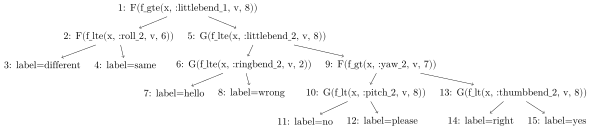

In [15]:
display(result; edgelabels=false) #suppress edge labels for clarity (left branch is true, right branch is false)

### Use the GBDT for prediction

Here, we'll predict the training data and evaluate the accuracy.

In [24]:
ind = collect(1:length(X))
y_pred = classify(result, X, ind)
accuracy = count(y_pred .== y[ind]) / length(ind)

1.0

### Determine the members of each node

In [29]:
mvec = node_members(result.tree, X, ind)
mvec[3] #members of node 3

27-element Array{Int64,1}:
 190
 191
 192
 193
 194
 195
 196
 197
 198
 199
 200
 201
 202
   ⋮
 205
 206
 207
 208
 209
 210
 211
 212
 213
 214
 215
 216